# Multichannel PINK-Files und Transformationen

Im Rahmen der Forschungsarbeit wurde bereits ein großes Subset der optischen und Radiobilder crossmatched. Es wurde hierzu das Complex "C" und Multiobject "M" - Subset
des Shimwellkatalogs als Radiobilder bezogen und das Katalogsubset sowie zugehörige PINK-File gespeichert.

Weiterhin wurde auf Basis dieses Subsets ein Crossmatching via PanSTARRS durchgeführt und alle optischen Matches heruntergeladen. Die hat nicht bei allen Radioquellen funktioniert, weshalb
ein crossmatch-Katalog erstellt wurde, der alle Objekte enthält, für die dieses Matching funktioniert hat.

Es liegen weiterhin zwei PINK-Dateien vor, die die zu dem Crossmatch-Katalog korrespondierenden Bilder im Radio- respektive optischen Bereich enthalten. Diese Dateien sind:


#### Der Crossmatch - Katalog
```
catalog_subset/pink_panstarrs_merged.parquet
```

#### Das Radio-PINK-File

```
pink_panstarrs_merged_radio.pink

```

#### Das optische PINK-File
```
pink_panstarrs_merged_optical.pink
```

Die drei Dateien sind nicht in diesem Repository enthalten, da diese zu groß sind. Sie liegen aber auf der Workstation von Herrn Rapp bereit.

## Erzeugung von Multichannelfiles


Die drei zuvor genannten Dateien liegen auf dem Compute-Server von Herrn Rapp bereit (TODO) und können als Startpunkt für Multichannelexperimente verwendet werden.
Es muss hierzu noch aus Radio- und optischem PINK-File ein Multichannel-PINK-File erzeugt werden.

Mit der weiter unten beschriebenen `transformation_function` lassen sich beliebig viele Transformationen für die beiden Channels des mehrkanaligen Output-PINK-Files
definieren und die verschiedenen Parametereinstellungen, wie im Bericht unter `docs/Projektbericht.pdf` beschrieben, realisieren.

In [1]:
# Notwendige Imports
import numpy as np
import pandas as pd
from hda_fits import image_processing as himg
from hda_fits import pink as hpink
from hda_fits import fits as hfits
from hda_fits import visualization as hviz

#


In [2]:
# catalog
filepath_catalog_merged_subset  = "data/catalog_subset/pink_panstarrs_merged.parquet"

# input pink
filepath_merged_subset_radio    = "data/pink_panstarrs_merged_radio.pink" 
filepath_merged_subset_optical  = "data/pink_panstarrs_merged_optical.pink"

# output
experiment_name = "my_experiment_name"
filepath_merged_multichannel    = f"../../data/pink/{experiment_name}.pink"
filepath_catalog_merged_written = f"../../data/catalog_subset/{experiment_name}.parquet"

### Hilfsfunktionen zum Lesen der Channel und Bilder und Channel des Multichannelpinkfiles

In [3]:
read_img = lambda i: hpink.read_pink_file_image(filepath_merged_multichannel, image_number=i) 
ira = lambda i: read_img(i)[0, :, :]
iop = lambda i: read_img(i)[1, :, :]

### Einlesen des Katalogs

In [4]:
cat = pd.read_parquet(filepath_catalog_merged_subset)

In [5]:
cat = cat[(cat["z_best"] >= 1.0) & (cat["z_best"] <= 6)]
cat

,img_idx_paper,img_idx_panstarrs,Source_Name,RA_x,E_RA_x,E_RA_tot,DEC_x,E_DEC_x,E_DEC_tot,Peak_flux_x,...,z_rest,U_rest,B_rest,V_rest,I_rest,J_rest,Ks_rest,w1_rest,w2_rest,w3_rest
15,26,19,ILTJ121926.61+495740.8,184.860885,0.006158,0.123717,49.961354,0.006279,0.123723,45.293116,...,-23.751795,-20.891985,-22.190447,-22.896528,-23.707153,-24.000249,-23.886473,-23.184687,NaN,NaN
24,45,30,ILTJ121833.75+493112.4,184.640644,0.116461,0.169797,49.520110,0.055617,0.135503,1.936046,...,-25.727898,-25.366306,-25.342175,-25.299222,-25.706628,-25.982764,-27.184427,-28.012164,-28.416065,-29.078862
31,58,40,ILTJ121808.46+502942.2,184.535241,0.011024,0.124054,50.495066,0.020717,0.125288,32.898853,...,-23.137424,-21.551641,-22.220367,-22.630433,-23.118988,-23.443051,-23.971835,-24.398071,-24.805187,NaN
44,77,55,ILTJ121709.43+492439.9,184.289294,0.023902,0.125854,49.411092,0.022060,0.125517,22.420458,...,-23.565595,-20.830135,-21.861883,-22.517012,-23.512151,-24.022666,-24.231473,-23.827272,NaN,NaN
68,117,85,ILTJ121521.54+502826.9,183.839739,0.012792,0.124224,50.474150,0.015518,0.124534,16.855614,...,-20.878185,-21.945628,-21.887067,-22.058001,-20.889670,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15562,24492,19106,ILTJ134742.13+490746.6,206.925547,0.112226,0.196015,49.129619,0.061289,0.171999,133.146311,...,-23.950285,-21.868169,-22.532897,-22.972637,-23.902388,-24.369037,-24.773733,-25.102521,NaN,NaN
15569,24500,19113,ILTJ134723.47+505227.1,206.847811,0.008321,0.160925,50.874216,0.010807,0.161072,37.141647,...,-23.885256,-22.673723,-23.018525,-23.255073,-23.852339,-24.168384,-24.761243,-25.319793,NaN,NaN
15621,24581,19180,ILTJ134345.25+492352.6,205.938524,0.047438,0.167564,49.397945,0.125583,0.203957,6.612604,...,-23.165934,-21.269063,-21.886249,-22.280065,-23.121485,-23.542866,-23.900471,-24.210175,-24.508358,NaN
15623,24584,19183,ILTJ134326.28+504012.9,205.859497,0.010438,0.161048,50.670263,0.006919,0.160858,102.156173,...,-21.594528,-21.211052,-21.458920,-21.471048,-21.583740,NaN,NaN,NaN,NaN,NaN


#### Die Transformationsfunktion

Mit dieser Funktion können beliebige Bildtransformationen / Preprocessing auf den rohen Inputbildern durchgeführt werden. Diese dient als modulare Datenpipeline.

In [6]:
def transformation_function(image_radio, image_optical, args={}):


    # Radio

    # Log-Skalierung des Radiokanals
    image_radio_log = himg.log_scale(image_radio)

    # Konvexe Hülle - Ausschnitt erzeugen
    image_radio_masked = himg.create_masked_image_convex_hull(
        image_for_mask_creation=image_radio_log,
        image_to_be_masked=image_radio_log,
        border_proportion=0.1,
        factor_std_convex_hull=5,
        factor_std_border=5,
        padding=5,
        fill_with=np.mean
    )

    # Entrauschung / Denoising des Radiokanals    
    image_radio_masked = himg.denoise_cutouts_from_mean(image_radio_masked)

    # Skalierung der Pixelwerte mit Wurzel
    image_radio_masked = np.sqrt(image_radio_masked)


    # Optisch
    # Kreisausschnitt auf Basis einer konvexen Hülle erzeugen
    image_optical_masked =himg.create_circular_masked_image_from_convex_hull(image_radio_masked,
                                                                              image_optical)

    # Entrauschung / Denoising durchführen
    image_data_optical = himg.denoise_cutouts_from_mean(image_optical_masked, sigma=2.5)
    
    # Gewichtung der Pixel mit 1/R wobei R = Abstand zu Zentrum
    image_data_optical = himg.create_weight_factors_euclidean_radius(image_data_optical)

    # Überführung der Bildmatrizen in "flache" Vektorstruktur
    image_data_radio = image_radio_masked.flatten()
    image_data_optical = image_data_optical.flatten()

    # Gewichtung der Bildkanäle
    image_data_radio /= image_data_radio.sum() 
    image_data_optical /= image_data_optical.sum()
    image_data_optical *= 0.1
    
    # Überprüfung, ob sich NaN oder INF-Werte gebildet haben
    # -> Bild wird dadurch für SOM-Algorithmus unbrauchbar
    # und wird deshalb nicht ins PINK-File geschrieben
    if not np.isfinite(image_data_radio).all():
        raise ValueError("NAN or INF")
    
    if not np.isfinite(image_data_optical).all():
        raise ValueError("NAN or INF")

    return image_data_radio, image_data_optical

#### Erzeugung des Multichannel PINK-Files

Die Funktion `write_multichannel_pink_file_from_catalog` iteriert über Objekte des Katalogs, die als Bilder in den beiden ebenfalls als Dateipfad-Parameter
übergebenen PINK-Files befinden. Hierbei wird auf jedem crossmatched Bildpaar die zuvor beschriebene Transformationsfunktion angewandt und das Bildpaar
als zusammengehöriges Multichannelimage in das zu erzeugende Multichannel-PINK-File geschrieben.

In [7]:
images_written = hpink.write_multichannel_pink_file_from_catalog(
    filepath_pink_output=filepath_merged_multichannel,
    filepath_pink_radio=filepath_merged_subset_radio,
    filepath_pink_optical=filepath_merged_subset_optical,
    catalog=cat,
    transformation_function=transformation_function
)
cat[images_written]

2022-01-09 11:01:45,745 pink.py: No points given
2022-01-09 11:01:45,761 pink.py: No points given
2022-01-09 11:01:45,786 pink.py: No points given
2022-01-09 11:01:45,847 pink.py: No points given
2022-01-09 11:01:45,888 pink.py: No points given
2022-01-09 11:01:45,893 pink.py: No points given
2022-01-09 11:01:51,140 pink.py: QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1560345721  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0



,img_idx_paper,img_idx_panstarrs,Source_Name,RA_x,E_RA_x,E_RA_tot,DEC_x,E_DEC_x,E_DEC_tot,Peak_flux_x,...,z_rest,U_rest,B_rest,V_rest,I_rest,J_rest,Ks_rest,w1_rest,w2_rest,w3_rest
15,26,19,ILTJ121926.61+495740.8,184.860885,0.006158,0.123717,49.961354,0.006279,0.123723,45.293116,...,-23.751795,-20.891985,-22.190447,-22.896528,-23.707153,-24.000249,-23.886473,-23.184687,NaN,NaN
24,45,30,ILTJ121833.75+493112.4,184.640644,0.116461,0.169797,49.520110,0.055617,0.135503,1.936046,...,-25.727898,-25.366306,-25.342175,-25.299222,-25.706628,-25.982764,-27.184427,-28.012164,-28.416065,-29.078862
31,58,40,ILTJ121808.46+502942.2,184.535241,0.011024,0.124054,50.495066,0.020717,0.125288,32.898853,...,-23.137424,-21.551641,-22.220367,-22.630433,-23.118988,-23.443051,-23.971835,-24.398071,-24.805187,NaN
44,77,55,ILTJ121709.43+492439.9,184.289294,0.023902,0.125854,49.411092,0.022060,0.125517,22.420458,...,-23.565595,-20.830135,-21.861883,-22.517012,-23.512151,-24.022666,-24.231473,-23.827272,NaN,NaN
68,117,85,ILTJ121521.54+502826.9,183.839739,0.012792,0.124224,50.474150,0.015518,0.124534,16.855614,...,-20.878185,-21.945628,-21.887067,-22.058001,-20.889670,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15562,24492,19106,ILTJ134742.13+490746.6,206.925547,0.112226,0.196015,49.129619,0.061289,0.171999,133.146311,...,-23.950285,-21.868169,-22.532897,-22.972637,-23.902388,-24.369037,-24.773733,-25.102521,NaN,NaN
15569,24500,19113,ILTJ134723.47+505227.1,206.847811,0.008321,0.160925,50.874216,0.010807,0.161072,37.141647,...,-23.885256,-22.673723,-23.018525,-23.255073,-23.852339,-24.168384,-24.761243,-25.319793,NaN,NaN
15621,24581,19180,ILTJ134345.25+492352.6,205.938524,0.047438,0.167564,49.397945,0.125583,0.203957,6.612604,...,-23.165934,-21.269063,-21.886249,-22.280065,-23.121485,-23.542866,-23.900471,-24.210175,-24.508358,NaN
15623,24584,19183,ILTJ134326.28+504012.9,205.859497,0.010438,0.161048,50.670263,0.006919,0.160858,102.156173,...,-21.594528,-21.211052,-21.458920,-21.471048,-21.583740,NaN,NaN,NaN,NaN,NaN


In [8]:
cat[images_written].to_parquet(filepath_catalog_merged_written)

### Visualisierung des Multichannel-PINK-Files

(<Figure size 1728x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

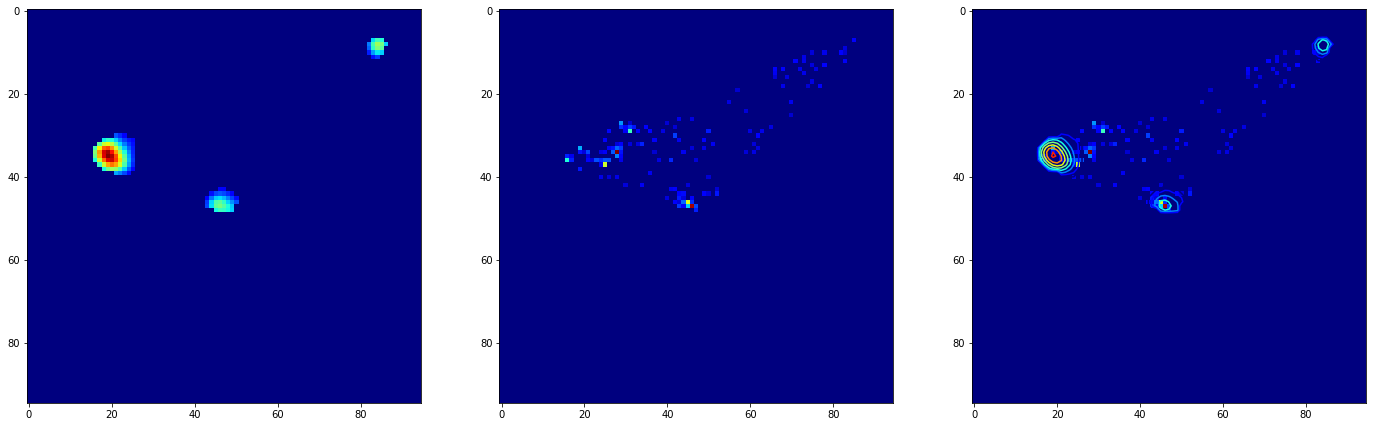

In [9]:
hviz.show_multichannel_image(filepath_merged_multichannel, 58)